<a href="https://colab.research.google.com/github/kimhwijin/HandsOnMachineLearing/blob/main/ComputerVision_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow import keras
from sklearn.datasets import load_sample_image
import matplotlib as mpl
np.random.seed(42)
tf.random.set_seed(42)

# Convolution_Tensorflow

In [2]:
#픽셀값을 0~1 로
china_image = load_sample_image("china.jpg") / 255.
flower_image = load_sample_image("flower.jpg") / 255.
images = np.array([china_image, flower_image])
batch_size, height, width, channels = images.shape
print(images.shape)

(2, 427, 640, 3)


(2, 427, 640, 2)


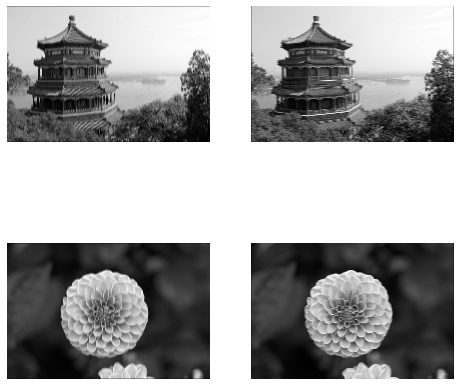

In [3]:
#2개의 수직, 수평 필터
filters = np.zeros(shape=(7,7, channels, 2), dtype=np.float32)
filters[:, 3, : ,0] = 1
filters[3, :, :, 1] = 1

#저수준 컨볼루션 뉴런 계산
outputs = tf.nn.conv2d(images, filters, strides=1, padding='SAME')
print(outputs.shape)

plt.figure(figsize=(8,8))
for image_index in (0, 1):    
    for feature_map_index in (0, 1):
        plt.subplot(2,2,image_index * 2 + feature_map_index + 1)
        plt.imshow(outputs[image_index, :, :, feature_map_index], cmap="gray", interpolation="nearest")
        plt.axis("off")
plt.show()

In [4]:
#고수준 케라스 컨볼루션 레이어
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')


# MaxPooling


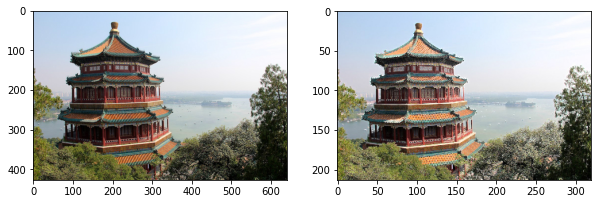

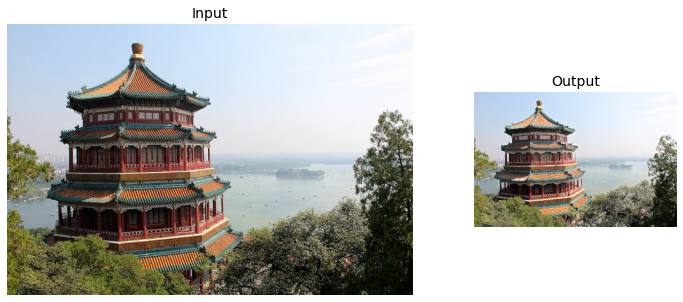

In [5]:
max_pool = keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid', input_shape=images.shape)
output = max_pool(images)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(images[0])
#plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(output[0])
#plt.axis("off")
plt.show()

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(images[0])  # 첫 번째 이미지 그리기
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # 첫 번째 이미지 출력 그리기
ax2.axis("off")
plt.show()

# Depth_Wise_Pooling

In [6]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding='VALID', **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size= pool_size
        self.strides = strides
        self.padding = padding

    def call(self, inputs):
        #batch, height, width, channel
        return tf.nn.max_pool(inputs, 
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.strides),
                              padding=self.padding
        )


depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"): # 아직 GPU 커널이 없습니다.
    depth_output = depth_pool(images)

print(images.shape, depth_output.shape, sep='\n')

(2, 427, 640, 3)
(2, 427, 640, 1)


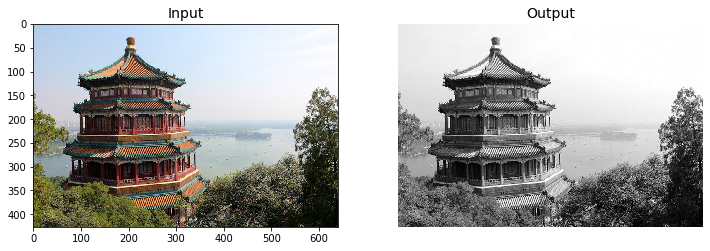

In [7]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plt.imshow(images[0], interpolation="nearest")  # 첫 번째 이미지 그리기
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plt.imshow(depth_output[0, ... , 0], cmap='gray', interpolation='nearest')  # 첫 번째 이미지 출력 그리기
plt.axis("off")
plt.show()
#채널이 색정보를 지닌 채널이기 때문에, RGB중 가장 강한 값을 추출한다.

# Global_Avg_Pooling

In [8]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_output = global_avg_pool(images)
print(images.shape, global_output.shape,global_output, sep='\n')

global_avg_pool_2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
global_output_2 = global_avg_pool_2(images)
print(global_output_2.shape, global_output_2, sep='\n')


(2, 427, 640, 3)
(2, 3)
tf.Tensor(
[[0.5675281  0.57046425 0.552622  ]
 [0.21621236 0.2885447  0.22353025]], shape=(2, 3), dtype=float32)
(2, 3)
tf.Tensor(
[[0.5675281  0.57046425 0.552622  ]
 [0.21621236 0.2885447  0.22353025]], shape=(2, 3), dtype=float32)


# MNIST_CNN_Model

In [9]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + keras.backend.epsilon()

X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]
print(X_train.shape)

4431872/4422102 [==============================] - 0s 0us/step
(55000, 28, 28, 1)


In [10]:
from functools import partial

HiddenConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding='same')

model = keras.models.Sequential([
    HiddenConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPool2D(pool_size=2),

    HiddenConv2D(filters=128),
    HiddenConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),

    HiddenConv2D(filters=256),
    HiddenConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),

    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax')

])

model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer="nadam", metrics=["accuracy"])

In [11]:
history = model.fit(X_train, y_train, epochs=10, validation_data=[X_valid, y_valid])
score = model.evaluate(X_test, y_test)
X_new = X_test[:15]
print(y_test[:15], tf.argmax(model.predict(X_new), axis=0), sep='\n')

Epoch 1/10
1719/1719 [==============================] - 15s 7ms/step - loss: 0.7124 - accuracy: 0.7510 - val_loss: 0.3796 - val_accuracy: 0.8584
Epoch 2/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.4145 - accuracy: 0.8597 - val_loss: 0.3192 - val_accuracy: 0.8834
Epoch 3/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.3564 - accuracy: 0.8810 - val_loss: 0.2947 - val_accuracy: 0.8948
Epoch 4/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3193 - accuracy: 0.8940 - val_loss: 0.2774 - val_accuracy: 0.8990
Epoch 5/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.3015 - accuracy: 0.8988 - val_loss: 0.2831 - val_accuracy: 0.9034
Epoch 6/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2862 - accuracy: 0.9034 - val_loss: 0.2950 - val_accuracy: 0.9004
Epoch 7/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.2715 - accuracy: 0.9066 - val_loss: 0.3067 - val_ac

# ResNet

In [12]:
Default_3x3_1S_Conv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1, padding='same', use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)

        self.main_layers = [
            Default_3x3_1S_Conv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            Default_3x3_1S_Conv2D(filters),
            keras.layers.BatchNormalization()
        ]

        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                Default_3x3_1S_Conv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()
            ]
        
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [13]:
model = keras.models.Sequential()
model.add(Default_3x3_1S_Conv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same'))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(Default_3x3_1S_Conv2D(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 56, 56, 64)        36864     
                                                                 
 conv2d_8 (Conv2D)           (None, 56, 56, 64)       

In [14]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102981632/102967424 [==============================] - 1s 0us/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


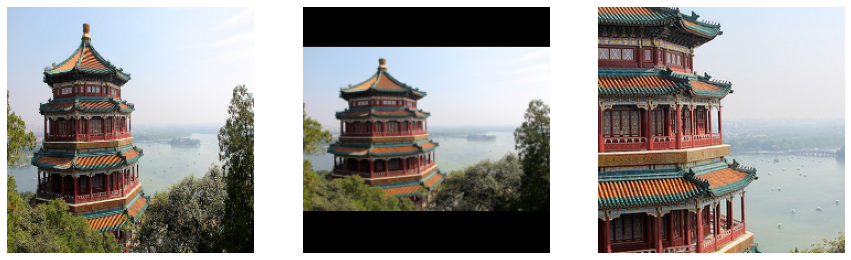

In [15]:
plt.figure(figsize=(15, 5))

images_resized = tf.image.resize(images, [224, 224])
plt.subplot(1, 3, 1)
plt.imshow(images_resized[0])
plt.axis("off")

images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plt.subplot(1, 3, 2)
plt.imshow(images_resized[0])
plt.axis("off")

images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plt.subplot(1, 3, 3)
plt.imshow(images_resized[0])
plt.axis("off")
plt.show()

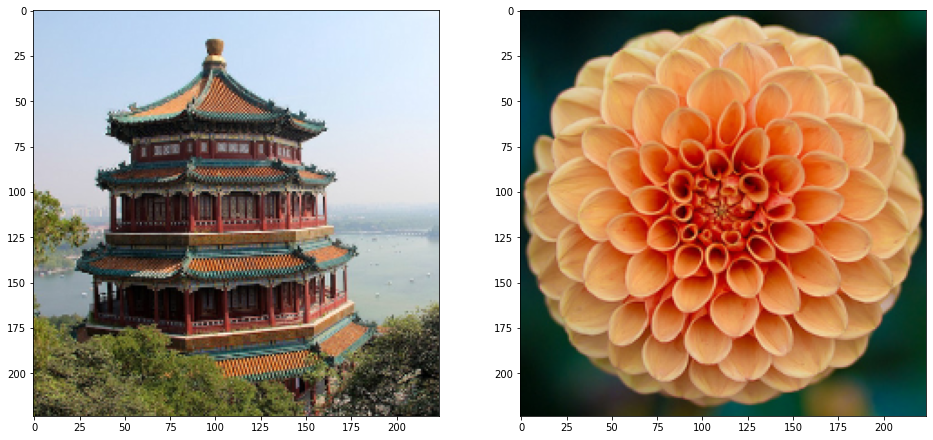

In [16]:
#crop with box
#y0, x0, y1, x1
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]

plt.figure(figsize=(16, 8))

images_resized = tf.image.crop_and_resize(images, boxes=[china_box, flower_box], box_indices=[0, 1], crop_size=[224, 224])
plt.subplot(1, 2, 1)
plt.axis=("off")
plt.imshow(images_resized[0])

plt.subplot(1, 2, 2)
plt.axis=("off")
plt.imshow(images_resized[1])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


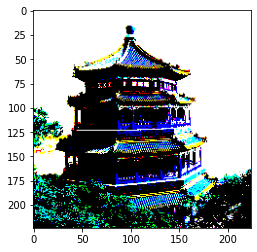

(2, 1000)
49152/35363 [=========================================] - 0s 0us/step
Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.07%
  n03781244 - monastery    11.70%

Image #1
  n04522168 - vase         53.96%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.97%



In [17]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
plt.imshow(inputs[0])
plt.show()

Y_proba = model.predict(inputs)
#1000개의 레이블 확률
print(Y_proba.shape)

top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

# Xception


In [19]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [27]:
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes
dataset_size = info.splits["train"].num_examples
print(info, class_names, n_classes, dataset_size, sep='\n')

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.1,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
5
3670


In [21]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load( "tf_flowers", split=["train[:10%]", "train[10%:25%]", "train[25%:]"], as_supervised=True)

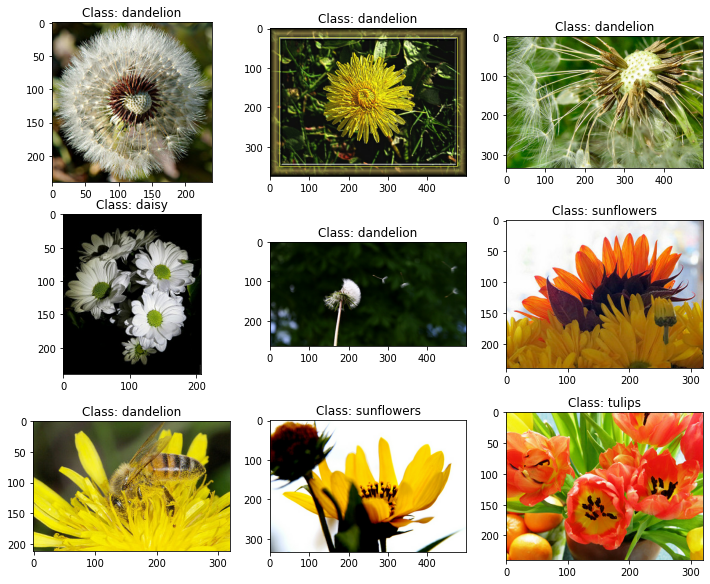

In [33]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    #plt.axis("off")

plt.show()

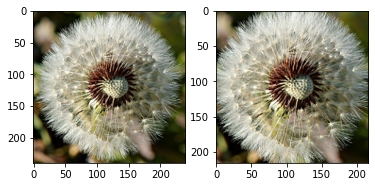

tf.Tensor([240 240   3], shape=(3,), dtype=int32)


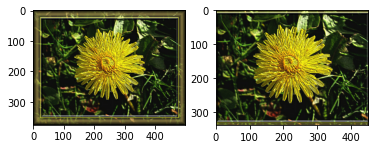

tf.Tensor([375 500   3], shape=(3,), dtype=int32)


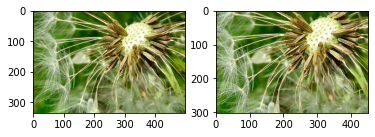

tf.Tensor([334 500   3], shape=(3,), dtype=int32)


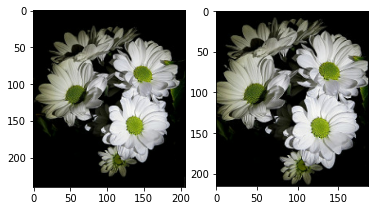

tf.Tensor([240 207   3], shape=(3,), dtype=int32)


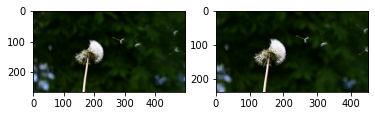

tf.Tensor([265 500   3], shape=(3,), dtype=int32)


In [43]:
#이미지 1개
def random_crop_90(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def central_crop(image):
    shape = tf.image(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1]) - min_dim // 4
    right_crop = shape[1] - left_crop
    return tf.image.central_crop(image, [top_crop])


for image , label in train_set_raw.take(5):
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(tf.image.central_crop(image, 0.9))
    plt.show()
    print(tf.shape(image))
